<a href="https://colab.research.google.com/github/alessandrossC/Detecting_Fake_News/blob/main/03_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import log_loss, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sentence_transformers import SentenceTransformer
from typing import Union

from tqdm.auto import tqdm

np.random.seed(7)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
DATA_PATH = '/content/processed'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv.zip'), compression='zip')
val_df = pd.read_csv(os.path.join(DATA_PATH, 'val.csv.zip'), compression='zip')

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def clean_text(text: Union[str, float]) -> str:
    """
    Perform basic text cleaning: lowercase, remove punctuation,
    and extra whitespace.

    Args:
        text (str or float): Input text.

    Returns:
        str: Cleaned text.
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text


In [ ]:
def get_embeddings(df: pd.DataFrame, model, device, col1='title_clean', col2='text_clean'):
    """
    Transform text columns to embeddings using SentenceTransformer.

    Args:
        df: DataFrame with text columns.
        model: Loaded SentenceTransformer model.
        device: torch.device ('cuda' or 'cpu').
        col1: Name of the first text column (default 'title_clean').
        col2: Name of the second text column (default 'text_clean').
    Returns:
        Tuple of (embeddings_col1, embeddings_col2)
    """
    text1 = df[col1].apply(clean_text).fillna("")
    text2 = df[col2].apply(clean_text).fillna("")

    embeddings1 = model.encode(
        text1.tolist(),
        show_progress_bar=True,
        convert_to_numpy=True,
        device=device
    )
    embeddings2 = model.encode(
        text2.tolist(),
        show_progress_bar=True,
        convert_to_numpy=True,
        device=device
    )
    return embeddings1, embeddings2

In [ ]:
print("Encoding from train set...")
title_train_embeddings, text_train_embeddings = get_embeddings(
    train_df, model, device, col1='title_clean', col2='text_clean'
)

print("Encoding from validation set...")
title_val_embeddings, text_val_embeddings = get_embeddings(
    val_df, model, device, col1='title_clean', col2='text_clean'
)
print("Successfully completed!")

Encoding from train set...


Batches:   0%|          | 0/894 [00:00<?, ?it/s]

Batches:   0%|          | 0/894 [00:00<?, ?it/s]

Encoding from validation set...


Batches:   0%|          | 0/224 [00:00<?, ?it/s]

Batches:   0%|          | 0/224 [00:00<?, ?it/s]

Successfully completed!


In [ ]:
def calculate_cosine_similarities(emb1: np.ndarray, emb2: np.ndarray) -> np.ndarray:
    """
    Векторизовано рахує cosine similarity між двома масивами embedding.
    Args:
        emb1: np.ndarray (n_samples, n_dim)
        emb2: np.ndarray (n_samples, n_dim)
    Returns:
        similarities: np.ndarray (n_samples,)
    """

    similarities = cosine_similarity(emb1, emb2)

    return np.diag(similarities)


In [ ]:
similarities_train = calculate_cosine_similarities(title_train_embeddings, text_train_embeddings)
similarities_val = calculate_cosine_similarities(title_val_embeddings, text_val_embeddings)

In [ ]:
# Cosine similarity is the only feature
X_train = similarities_train.reshape(-1, 1)
y_train = train_df['is_fake'].values

X_val = similarities_val.reshape(-1, 1)
y_val = val_df['is_fake'].values

# Fit calibration model (Logistic Regression)
calibrator = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=7)
calibrator.fit(X_train, y_train)

# Predict calibrated probabilities
y_pred_probs_train = calibrator.predict_proba(X_train)
y_pred_probs_val = calibrator.predict_proba(X_val)
y_pred_val = calibrator.predict(X_val)

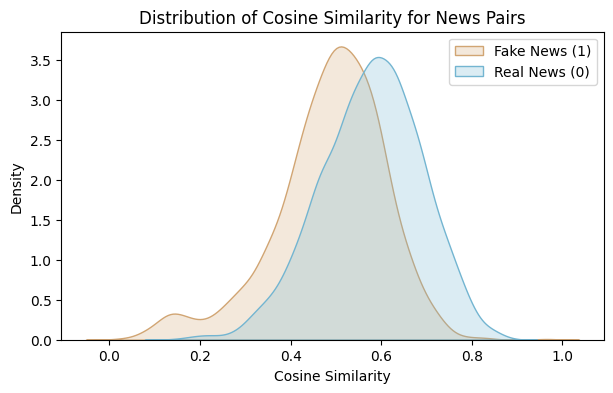

In [ ]:
# Separate cosine similarity scores for the two classes
fake_news = X_val[y_val == 1].flatten()     # Фейкові новини
real_news = X_val[y_val == 0].flatten()     # Реальні новини

plt.figure(figsize=(7, 4))
sns.kdeplot(fake_news, label='Fake News (1)', fill=True, color='#D1A573')
sns.kdeplot(real_news, label='Real News (0)', fill=True, color='#73B5D1')
plt.title('Distribution of Cosine Similarity for News Pairs')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
def evaluate_model(X_train, X_val, y_train, y_val, model):
    """
    Оцінює log loss на тренувальній і валідаційній вибірках для заданої моделі.
    """
    y_pred_probs_train = model.predict_proba(X_train)
    y_pred_probs_val = model.predict_proba(X_val)
    log_loss_train = log_loss(y_train, y_pred_probs_train)
    log_loss_val = log_loss(y_val, y_pred_probs_val)
    return log_loss_train, log_loss_val

In [ ]:
log_loss_train, log_loss_val = evaluate_model(
    X_train, X_val, y_train, y_val, calibrator
)

print(f"Log loss on Train set: {log_loss_train:.4f}")
print(f"Log Loss on Validation set: {log_loss_val:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val, digits=3))

Log loss on Train set: 0.6243
Log Loss on Validation set: 0.6234

Classification Report:
              precision    recall  f1-score   support

           0      0.615     0.663     0.638      3394
           1      0.672     0.626     0.648      3755

    accuracy                          0.643      7149
   macro avg      0.644     0.644     0.643      7149
weighted avg      0.645     0.643     0.643      7149



The cosine similarity between the sentence embeddings of the title and the text provides a meaningful signal for fake news detection, achieving a log loss of ~0.62 and accuracy of 64%.
However, this single feature is much less effective than the full TF-IDF and engineered feature set, which previously achieved a log loss of ~0.03 and accuracy above 99%.
Therefore, cosine similarity is a strong feature for baseline models, but should ideally be combined with other features for the best performance.

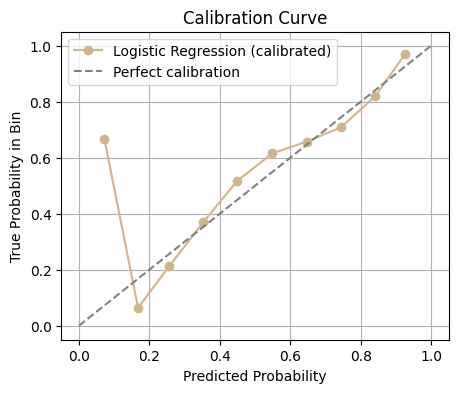

In [ ]:
# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_val, y_pred_probs_val[:, 1], n_bins=10)

plt.figure(figsize=(5, 4))
plt.plot(prob_pred, prob_true, marker='o', color='tan', label='Logistic Regression (calibrated)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')

plt.title('Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability in Bin')
plt.legend()
plt.grid(True)
plt.show()

The model is well-calibrated for most probability ranges, as the calibration curve closely follows the diagonal. Some instability appears at very low predicted probabilities, likely due to a small number of samples or class imbalance in those bins. Overall, predicted probabilities can be trusted, especially in the middle and higher probability ranges.